In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

/home/karan_kant2/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
PATH = "../chrc_data_segments/"
sz=256

In [6]:
torch.cuda.is_available()

True

In [7]:
os.listdir(PATH)

['train', 'valid', '.ipynb_checkpoints']

In [9]:
files = os.listdir(f'{PATH}valid/Celiac')[:5]
files

['C11-54_02_7326_18981.jpg',
 'C11-55_01_8500_4500.jpg',
 'C14-71_01_3330_2331.jpg',
 'C10-51_02_9657_3330.jpg',
 'C11-55_01_4329_1332.jpg']

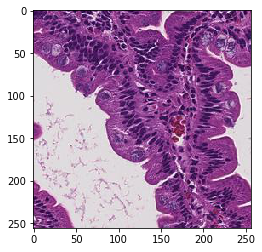

In [10]:
img = plt.imread(f'{PATH}valid/Celiac/{files[0]}')
plt.imshow(img);

In [11]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))


In [12]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
lrf=learn.lr_find()

100%|██████████| 1288/1288 [12:08<00:00,  2.12it/s]


 79%|███████▉  | 3415/4324 [05:30<01:35,  9.51it/s, loss=1.36] 

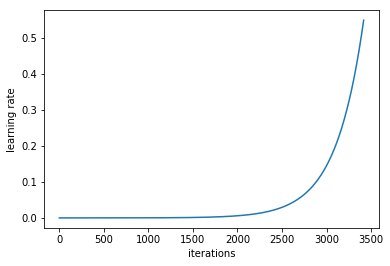

In [14]:
learn.sched.plot_lr()

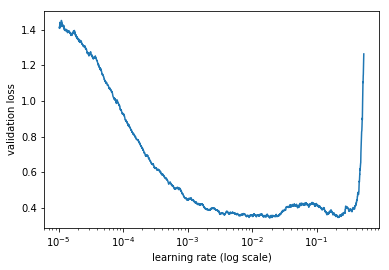

In [15]:
learn.sched.plot()

In [ ]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [13]:
### Fine-tuning and differential learning rate annealing 
#Now that we have a good final layer trained, we can try fine-tuning 
#the other layers. To tell the learner that we want to unfreeze the remaining 
#layers, just call (surprise surprise!) `unfreeze()`.

In [ ]:
#implement data augmentation

In [16]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [17]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [18]:
ims = np.stack([get_augs() for i in range(6)])

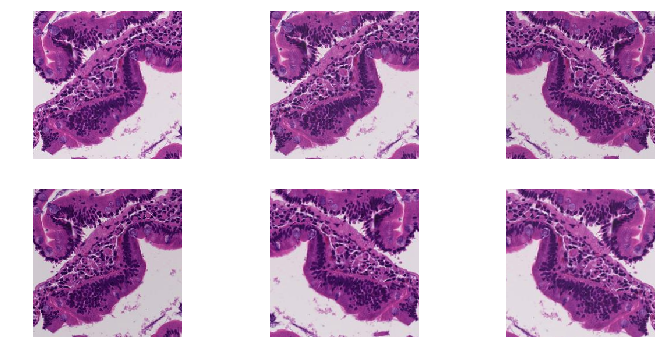

In [20]:
plots(ims, rows=2)

In [21]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [25]:
learn.unfreeze()

In [28]:
lr=np.array([2e-5,2e-4,2e-3])

In [29]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                          
    0      0.20574    0.140287   0.936679  
    1      0.157817   0.117914   0.946691                          
    2      0.161075   0.11369    0.948244                          


[array([0.11369]), 0.9482440599086773]

In [ ]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [ ]:
accuracy_np(probs, y)

In [ ]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

In [ ]:
plot_confusion_matrix(cm, data.classes)

In [ ]:
learn.save('karan_2e')